# Hospital - Customer Segmentation & Churn Model

In [ ]:
# Import necessary libraries

import numpy as np  # For numerical operations and array manipulation
import pandas as pd  # For data manipulation and analysis
import datetime as dt  # For handling date and time operations
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For making statistical graphics more informative

# Import warning control and preprocessing tools
import warnings  # For controlling warning messages
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.cluster import KMeans  # For performing K-means clustering
from yellowbrick.cluster import KElbowVisualizer  # For determining the optimal number of clusters using the elbow method
from sklearn.exceptions import ConvergenceWarning  # To handle specific convergence warnings in models

# Import tools for data preprocessing and model evaluation
from sklearn.preprocessing import LabelEncoder  # For encoding categorical variables into numeric labels
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV  # For splitting data and performing cross-validation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score  # For evaluating model performance

# Import machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Random Forest and Gradient Boosting models
from xgboost import XGBClassifier  # XGBoost model, a powerful gradient boosting algorithm
from lightgbm import LGBMClassifier  # LightGBM model, another gradient boosting framework
from catboost import CatBoostClassifier  # CatBoost model, gradient boosting model optimized for categorical data
from xgboost import plot_importance  # For plotting feature importance in XGBoost

# Import joblib for saving and loading machine learning models
import joblib  # For saving models as .pkl files and loading them later

# Ignore specific warnings to keep the output clean
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore FutureWarning messages
warnings.simplefilter("ignore", category=ConvergenceWarning)  # Ignore ConvergenceWarning messages

# Set Pandas display options for better output readability
pd.set_option('display.max_columns', None)  # Show all columns when displaying DataFrames
pd.set_option('display.max_rows', None)  # Show all rows when displaying DataFrames
pd.set_option('display.width', None)  # Adjust the display width for DataFrames
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format float numbers to three decimal places


In [ ]:
# Load data
df_ = pd.read_excel(r"data/2023_Ver.xlsx")  # Add the path to your data file
df = df_.copy() # Copy the data
df.head()  # Display the first few rows to understand the structure of the data

In [ ]:
# Check the shape and number of unique values in each column
print(df.shape)
df.nunique()

The data contains 374,672 rows and the following unique values:
- Müşteri ID: 374,672 IDs (Number of patients)
- Cinsiyet: 2 unique values (Gender)
- Yaş: 8,926 unique values (Age)
- Şehir: 81 unique values (City)
- İlçe: 598 unique values (District)
- İşlem Tarihi: 369,763 unique values (Transaction Date)
- Yerli-Yabancı Hasta: 140 unique values (Local-Foreign Patient)
- Sigorta Türü(KURUM): 126 unique values (Insurance Type)
- Sigorta Türü(EK KURUM): 151 unique values (Additional Insurance Type)
- Ayaktan /Yatan Hasta: 5 unique values (Outpatient/Inpatient)
- Tedavi Adı: 2,671 unique values (Treatment Name)
- Hizmet aldığı Branş: 34 unique values (Branch)
- İletişim Kanalı : 2 unique values (Communication Channel)
- Toplam Harcama: 99,235 unique values (Total Expense)

## Data Cleaning & Preprocessing

In [ ]:
# The dataset contains unique values and may have duplicate customers under different categories.
# To identify unique patients, we'll create a new 'Birleşik' feature by combining several relevant columns.
df['Birleşik'] = df['Cinsiyet'] + df['Yaş'].astype(str) + df['Şehir'] + df['İlçe'] + df['Yerli-Yabancı Hasta'] + df['Sigorta Türü(KURUM)'] + df['Ayaktan /Yatan Hasta']

# Assign a unique customer ID to each unique combination in the 'Birleşik' column
df['Müşteri_ID'] = df.groupby('Birleşik').ngroup()
df["Müşteri_ID"].nunique()  # There are 146,714 unique customers in the dataset
df["Müşteri ID"].nunique()  # The original 'Müşteri ID' column had 374,672 rows (total customers who visited the hospital during the period

In [ ]:
# General overview of the dataset
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

In [ ]:
# Dropping columns and handling missing values
df.drop(["Sigorta Türü(EK KURUM)"], axis=1, inplace=True)  # Drop the 'Sigorta Türü(EK KURUM)' column due to excessive missing values
df.dropna(subset=["Şehir"], inplace=True)  # Drop rows with missing values in the 'Şehir' column due to few missing values
df.dropna(subset=["İlçe"], inplace=True)  # Drop rows with missing values in the 'İlçe' column due to few missing values
df.drop(["Müşteri ID", "Birleşik"], axis=1, inplace=True)  # Drop unnecessary columns now that we have a unique 'Müşteri_ID'

# Renaming some columns for simplicity and readability
df.rename(columns={"Sigorta Türü(KURUM)": "Sigorta Türü"}, inplace=True)
df.rename(columns={"Ayaktan /Yatan Hasta": "Hasta Türü"}, inplace=True)

## Exploratory Data Analysis- 1

In [ ]:
# Function to identify categorical and numerical columns
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    This function identifies categorical, numerical, and cardinal categorical columns in the given dataframe.

    :param dataframe: DataFrame to analyze
    :param cat_th: Threshold for categorical columns
    :param car_th: Threshold for cardinal columns
    :return: Lists of categorical, numerical, and cardinal categorical columns
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols, num_but_cat

cat_cols, cat_but_car, num_cols = grab_col_names(df)

In [ ]:
# Review unique value counts to identify potential feature engineering opportunities
df.nunique()

# Consolidate categories for several columns to reduce cardinality
df["Yerli-Yabancı Hasta"] = np.where(df["Yerli-Yabancı Hasta"] == "TÜRKİYE CUMHURİYETİ", "Yerli", "Yabancı")  # Consolidate 'Yerli-Yabancı Hasta' into two categories

df["Sigorta Türü"] = df["Sigorta Türü"].apply(lambda x: x if x in ["SSK", "BAĞKUR", "EMEKLİ SANDIĞI", "ÜCRETLİ HASTA"] else "ÖZEL SAĞLIK")  # Consolidate 'Sigorta Türü' into five categories

df["Şehir"] = np.where(df["Şehir"] == "İSTANBUL", "İstanbul", "Şehir Dışı")  # Consolidate 'Şehir' into two categories

# Consolidate 'İlçe' into fewer categories based on frequency
conditions = [
    df["İlçe"] == "ŞİŞLİ",
    df["İlçe"] == "KAĞITHANE",
    df["İlçe"] == "BEYOĞLU",
    df["İlçe"] == "İSTANBUL",
    df["İlçe"] == "SARIYER",
    df["İlçe"] == "EYÜP",
    df["İlçe"] == "BEŞİKTAŞ"
]
choices = ["ŞİŞLİ", "KAĞITHANE", "BEYOĞLU", "İSTANBUL", "SARIYER", "EYÜP", "BEŞİKTAŞ"]
df["İlçe"] = np.select(conditions, choices, default="DİĞER")

In [ ]:
# Create a new feature as column 'Bölge' based on 'İlçe'
conditions2 = [
    df["İlçe"].isin(["ŞİŞLİ", "KAĞITHANE", "BEYOĞLU", "İSTANBUL"]),
    df["İlçe"].isin(["SARIYER", "EYÜP", "BEŞİKTAŞ"])
]
choices2 = ['1. Bölge', '2. Bölge']
df["Bölge"] = np.select(conditions2, choices2, default="3. Bölge")

In [ ]:
# Simplify 'Hizmet aldığı Branş' into three categories based on frequency
brans_sayilari = df["Hizmet aldığı Branş"].value_counts()
dusuk_yogunluklu_branslar = brans_sayilari[brans_sayilari < 1000].index
df.loc[df["Hizmet aldığı Branş"].isin(dusuk_yogunluklu_branslar), "Branş Yoğunluğu"] = "Düşük-Yoğun Branş"
orta_yogunluklu_branslar = brans_sayilari[(brans_sayilari >= 1000) & (brans_sayilari < 10000)].index
df.loc[df["Hizmet aldığı Branş"].isin(orta_yogunluklu_branslar), "Branş Yoğunluğu"] = "Orta-Yoğun Branş"
yuksek_yogunluklu_branslar = brans_sayilari[(brans_sayilari >= 10000)].index
df.loc[df["Hizmet aldığı Branş"].isin(yuksek_yogunluklu_branslar), "Branş Yoğunluğu"] = "Yüksek-Yoğun Branş"

In [ ]:
# Create age groups based on domain knowledge
df["Yaş Grubu"] = pd.cut(x=df["Yaş"],
                         bins=[0, 2, 12, 18, 40, 70, 85, 105],
                         labels=["Bebek", "Çocuk", "Ergen","Genç", "Yetişkin", "Orta Düzey Yaşlı", "İleri Düzey Yaşlı"])


In [ ]:
# Simplify 'Tedavi Adı' by keeping only the first part before the comma
df["Tedavi Adı"] = df["Tedavi Adı"].str.split(',').str[0]
df["Tedavi Adı"].nunique()  # The number of unique treatment types has decreased

# Classify 'Tedavi Adı' into four categories based on frequency
tedavi = df["Tedavi Adı"].value_counts().sort_values(ascending=False)
ilk_40_tedavi = df["Tedavi Adı"].value_counts().head(40).index  # First 40 most common treatments
tedavi_40_100 = tedavi[40:100].index  # Treatments ranked 40 to 100
tedavi_100_200 = tedavi[100:200].index  # Treatments ranked 100 to 200
diger_tedaviler = tedavi[200:2228].index  # Treatments ranked 200 to 2228

# Classify treatments into four categories: 'En Yaygın', 'Sık Yapılan', 'Orta Sıklıkta', 'Nadir Yapılan'
df.loc[df["Tedavi Adı"].isin(ilk_40_tedavi), "Tedavi Sınıflandırması"] = "En Yaygın"
df.loc[df["Tedavi Adı"].isin(tedavi_40_100), "Tedavi Sınıflandırması"] = "Sık Yapılan"
df.loc[df["Tedavi Adı"].isin(tedavi_100_200), "Tedavi Sınıflandırması"] = "Orta Sıklıkta"
df.loc[df["Tedavi Adı"].isin(diger_tedaviler), "Tedavi Sınıflandırması"] = "Nadir Yapılan"

In [ ]:
# Re-run the function to get updated lists of categorical, cardinal, and numerical columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

After domain knowledge-based modifications, we now have:
- 17 variables
- 11 categorical columns
- 4 numerical columns
- 2 high-cardinality categorical columns

In [ ]:
df.nunique()

After consolidation:
- Cinsiyet: 2 unique values
- Yaş: 8926 unique values
- Şehir: 2 unique values
- İlçe: 8 unique values
- İşlem Tarihi: 369288 unique values
- Yerli-Yabancı Hasta: 2 unique values
- Sigorta Türü: 4 unique values
- Hasta Türü: 5 unique values
- Tedavi Adı: 2228 unique values
- Hizmet aldığı Branş: 34 unique values
- İletişim Kanalı: 2 unique values
- Toplam Harcama: 99055 unique values
- Müşteri_ID: 146714 unique values
- Bölge: 3 unique values
- Branş Yoğunluğu: 3 unique values
- Yaş Grubu: 7 unique values
- Tedavi Sınıflandırması: 4 unique values

In [ ]:
# Analyze categorical variables
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

    print("#####################################")

# Summarize each categorical variable
for col in cat_cols:
    cat_summary(df, col)

In [ ]:
# Analyze numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=False)

    print("#####################################")

# Summarize each numerical variable
for col in num_cols:
    num_summary(df, col)

In [ ]:
# Identify and handle negative 'Toplam Harcama' values
df[df["Toplam Harcama"] < 0].value_counts()  # Check for negative values
df = df[df["Toplam Harcama"] >= 0]  # Remove rows with negative 'Toplam Harcama' values

## CRM Analysis

### RFML Model

In [ ]:
# Identify top 10 customers by total spending
df.groupby("Müşteri_ID").agg({"Toplam Harcama": "sum"}).sort_values("Toplam Harcama", ascending=False).head(10)

# Define the analysis date as two days after the last transaction date in the dataset
df["İşlem Tarihi"].min()  # Earliest transaction date: 2023-01-01
df["İşlem Tarihi"].max()  # Latest transaction date: 2024-02-13
analysis_date = dt.datetime(2024, 2, 15)

In [ ]:
# Calculate RFM (Recency, Frequency, Monetary) and Length metrics for each customer
rfml = df.groupby("Müşteri_ID").agg(
    Recency=("İşlem Tarihi", lambda x: (analysis_date - x.max()).days),  # Days since last transaction
    Frequency=("Müşteri_ID", "count"),  # Number of transactions
    Monetary=("Toplam Harcama", "sum"),  # Total spending
    Length=("İşlem Tarihi", lambda x: (analysis_date - x.min()).days)  # Duration of customer relationship
)

In [ ]:
# Sort customers by each metric to identify key patterns
rfml.sort_values(by="Frequency", ascending=False).head(10)  # Top 10 by Frequency
rfml.sort_values(by="Recency", ascending=True).head(10)  # Top 10 by Recency (most recent customers)
rfml.sort_values(by="Monetary", ascending=False).head(10)  # Top 10 by Monetary (highest spenders)
rfml.sort_values(by="Length", ascending=False).head(10)  # Top 10 by Length (longest relationships)

In [ ]:
# Summary statistics for RFML metrics
print(rfml.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
print(rfml.shape)  # There are 146,714 unique customers

In [ ]:
# To better segment customers, we can use K-Means clustering. First, let's check for skewness in the data.

# Check for skewness in the distribution of each RFM metric
from scipy import stats
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.displot(df_skew, x=column, color="g", kde=True)
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(rfml, "Recency")
plt.subplot(6, 1, 2)
check_skew(rfml, "Frequency")
plt.subplot(6, 1, 3)
check_skew(rfml, "Monetary")
plt.subplot(6, 1, 4)
check_skew(rfml, "Length")

plt.tight_layout()
plt.savefig("before_transform.png", format="png", dpi=1000)
plt.show()


Skewness analysis:
- Recency: Skewness of 0.47, indicating a slight right skew. Most customers have recent transactions.
- Frequency: Skewness of 3.96, indicating a significant right skew. Most customers have a low transaction frequency, with a few having very high frequency.
- Monetary: Skewness of 17.73, indicating a highly right-skewed distribution. Most customers have low spending, with a few high spenders.
- Length: Skewness of -0.36, indicating a slight left skew. Most customer relationships are long-term.

To address skewness, we'll apply log transformation.

In [ ]:
# Apply log transformation to normalize the data
rfml["Recency"] = np.log1p(rfml["Recency"])
rfml["Frequency"] = np.log1p(rfml["Frequency"])
rfml["Monetary"] = np.log1p(rfml["Monetary"])
rfml["Length"] = np.log1p(rfml["Length"])
rfml.head()

# Scale the RFML metrics using MinMaxScaler
sc = MinMaxScaler((0, 1))
rfml_scaled = sc.fit_transform(rfml)
rfml = pd.DataFrame(rfml_scaled, columns=rfml.columns)

### K-Means Clustering Analysis

In [ ]:
# Determine the optimal number of clusters using the Elbow method
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(rfml)
elbow.show()  # The optimal number of clusters is 6

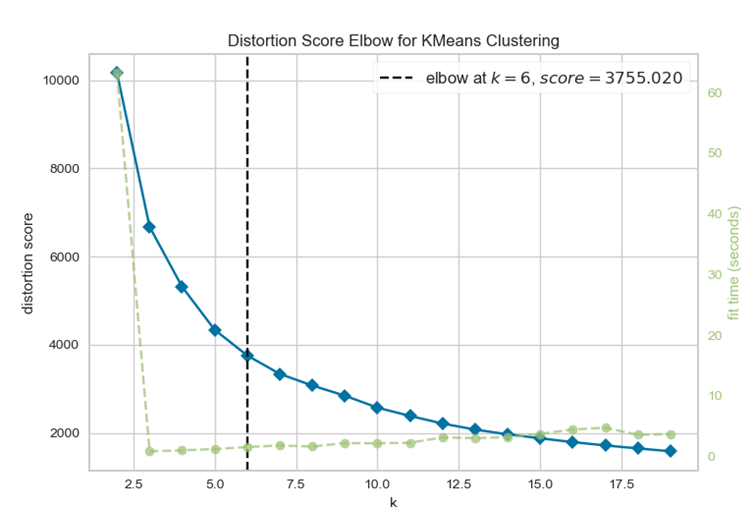

In [ ]:
# Perform K-Means clustering with the identified optimal number of clusters
k_means = KMeans(n_clusters=6, random_state=42).fit(rfml)
segments = k_means.labels_  # Assign cluster labels to each customer
print(segments)  # Display the cluster assignments for each customer

# Reverse the scaling to return to the original RFML values
rfml_new = sc.inverse_transform(rfml)
rfml_new = pd.DataFrame(rfml_new, columns=rfml.columns)
rfml_new.head()

# Add the cluster labels to the DataFrame
final_rfml = rfml_new
final_rfml["segment"] = segments + 1  # Shift segment labels to start from 1 instead of 0
final_rfml.head()

### Segment Evaluation

In [ ]:
# Reset the index to have a clean DataFrame
final_rfml = final_rfml.reset_index()
print(final_rfml.columns)
final_rfml.rename(columns={"index": "Müşteri_ID"}, inplace=True)  # Rename index to 'Müşteri_ID'

# Analyze each segment statistically
final_rfml.groupby("segment").agg({"Recency": ["mean", "min", "max"],
                                   "Frequency": ["mean", "min", "max"],
                                   "Monetary": ["mean", "min", "max"],
                                   "Length": ["mean", "min", "max"]})

Segment 1:
- Recency: Average of 4.455 days. Transactions occurred relatively recently.
- Frequency: Average of 1.904. This segment has the highest transaction frequency.
- Monetary: Average of 8.252. This is the highest spending segment.
- Length: Average of 5.843, indicating long-term customers.

Suggested Strategy: Segment 1 contains high-value customers. Loyalty programs and premium offers should be targeted to increase engagement.

Segment 2:
- Recency: Average of 5.211 days. Moderately recent transactions.
- Frequency: Average of 0.865. Low transaction frequency.
- Monetary: Average of 7.121. Good spending average.
- Length: Average of 5.405, indicating long-term customers.

Suggested Strategy: Segment 2 consists of customers with low frequency but high monetary value. Promotions and discounts could be offered to encourage more frequent purchases.

Segment 3:
- Recency: Average of 5.737 days. Less recent compared to other segments.
- Frequency: Average of 0.854. Low transaction frequency.
- Monetary: Average of 6.783. Below-average spending.

Suggested Strategy: Segment 3 needs improvement in both frequency and spending. Email campaigns or special offers could be sent to encourage purchases.

Segment 4:
- Recency: Average of 4.706 days. New customers.
- Frequency: Average of 0.859. Low frequency.
- Monetary: Average of 7.204. Good spending average.
- Length: Average of 4.850, indicating relatively new customers.

Suggested Strategy: Segment 4 consists of new and high-spending customers. Welcome offers and discounts for first-time purchases could be used to build loyalty.

Segment 5:
- Recency: Average of 4.154 days. The newest customers.
- Frequency: Average of 0.747. The lowest transaction frequency.
- Monetary: Average of 6.669. Low spending.

Suggested Strategy: Segment 5 consists of new customers with low spending. Campaigns should be targeted to increase both frequency and spending.

Segment 6:
- Recency: Average of 5.354 days. Moderately recent transactions.
- Frequency: Average of 0.793. Low frequency.
- Monetary: Average of 0.046. Extremely low spending.
- Length: Average of 5.454, indicating long-term customers.

Suggested Strategy: Segment 6 consists of long-term customers with very low spending. Special offers and re-engagement strategies should be applied.


Determine which customers are most valuable based on segment analysis

Customer Importance:
1. Segment 1: High Frequency, High Monetary.
   - Frequent and high-spending customers. This segment is the most valuable.
2. Segment 2: Low Frequency, High Monetary.
   - Infrequent but high-spending customers. Important for revenue.
3. Segment 4: Low Frequency, Medium Monetary.
   - Infrequent but significant contributors to revenue.
4. Segment 3: Low Frequency, Medium Monetary.
   - Similar to Segment 4 but slightly lower spending.
5. Segment 5: Low Frequency, Low Monetary.
   - Low importance in terms of frequency and spending.
6. Segment 6: Very Low Monetary, Low Frequency.
   - The least important segment in terms of both frequency and spending.

Prioritization: Segment 1 > Segment 2 > Segment 4 > Segment 3 > Segment 5 > Segment 6 # According to my strategy


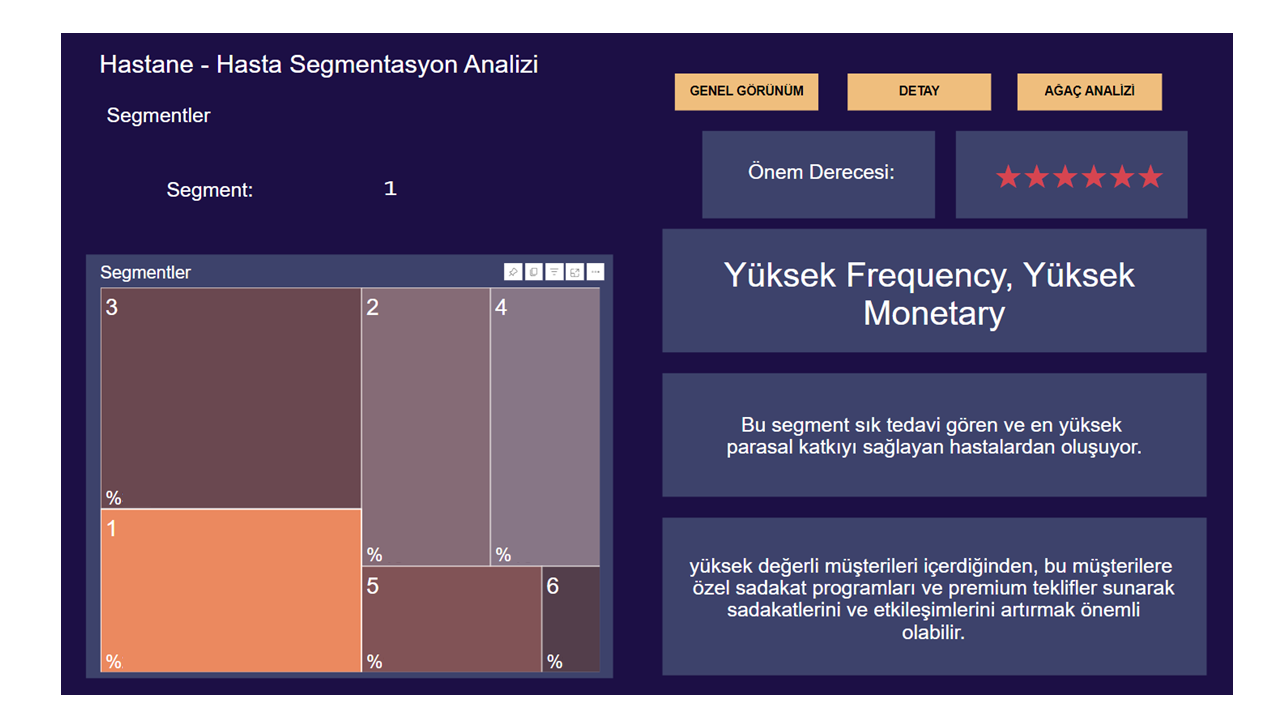

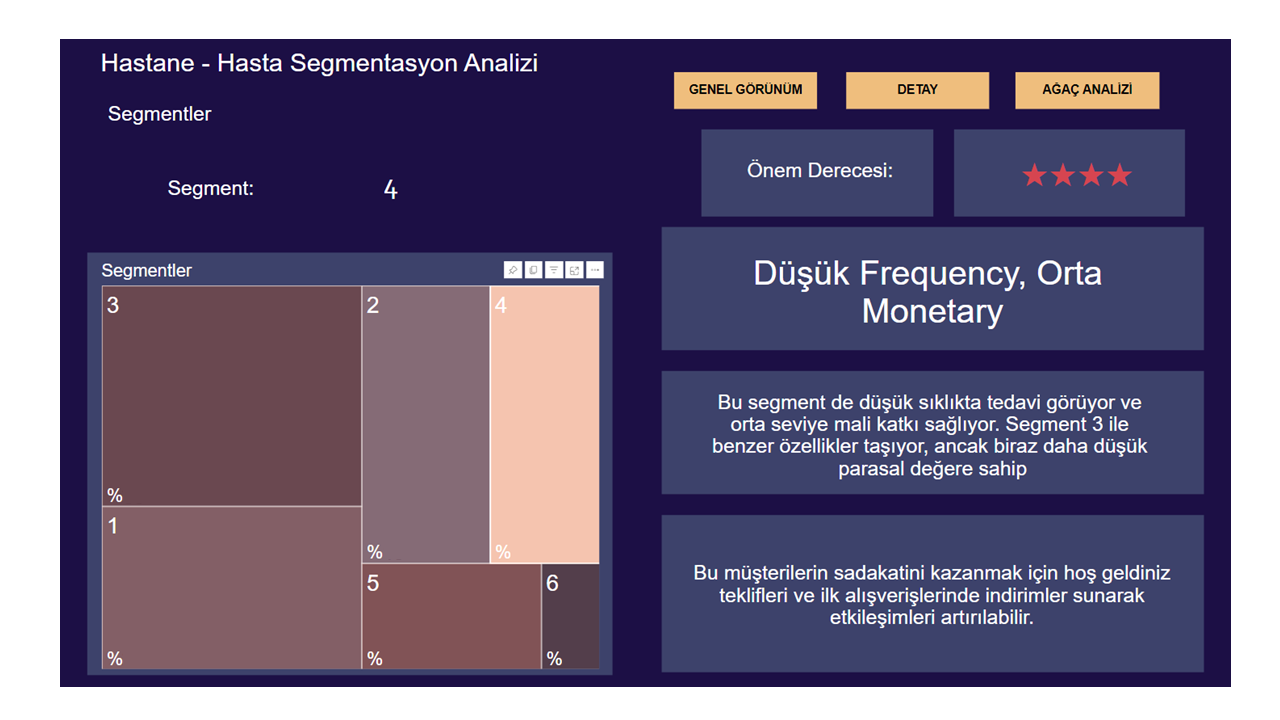

In [ ]:
# Extract the IDs of customers in the most valuable segment (Segment 1)
segment1 = final_rfml[final_rfml["segment"] == 1]
segment1.value_counts().sum()  # Number of customer in segment 1
segment1_ids = segment1[["Müşteri_ID"]]  # Extract only the customer IDs
segment1_ids.to_csv('segment1_ids.csv', index=False)  # Save the IDs to a CSV file
print(segment1.columns)

### Identifying Churn-Prone Segments 

In [ ]:
# Calculate the proportion of each segment in the total customer base
total_entries = len(final_rfml)
segment_ratios = {}

for segment in range(1, 7):
        segment_data = final_rfml[final_rfml["segment"] == segment]
        segment_ratios[segment] = len(segment_data) / total_entries

for segment, ratio in segment_ratios.items():
    print(f"Segment {segment}: %{ratio * 100:.2f}")

Segment proportions:
Based on this analysis and domain knowledge, the segments with the highest churn risk are: Segment 2, Segment 3, and Segment 6, accounting for 51.9% of the customers.
Segments with higher loyalty are: Segment 1, Segment 4, and Segment 5, accounting for 48.11% of the customers.

In [ ]:
# Add segment information to the main dataset
new_final_rfml = final_rfml.drop(columns=["Frequency", "Monetary", "Length", "Recency"])
new_final_rfml.head()

df_merged = pd.merge(df, new_final_rfml, on="Müşteri_ID", how='left')  # Merge the segment information back into the main dataset
df_merged.head()

# Assign a churn flag based on the segments. Segments 2, 3, and 6 are churn-prone.
df_merged["Churn"] = df_merged["segment"].apply(lambda x: 1 if x in [2, 3, 6] else 0)

df_merged.to_csv("df_merged.csv", index=False)  # Save the merged dataset to a CSV file to use for CRM Analysis in Power BI Dashboard

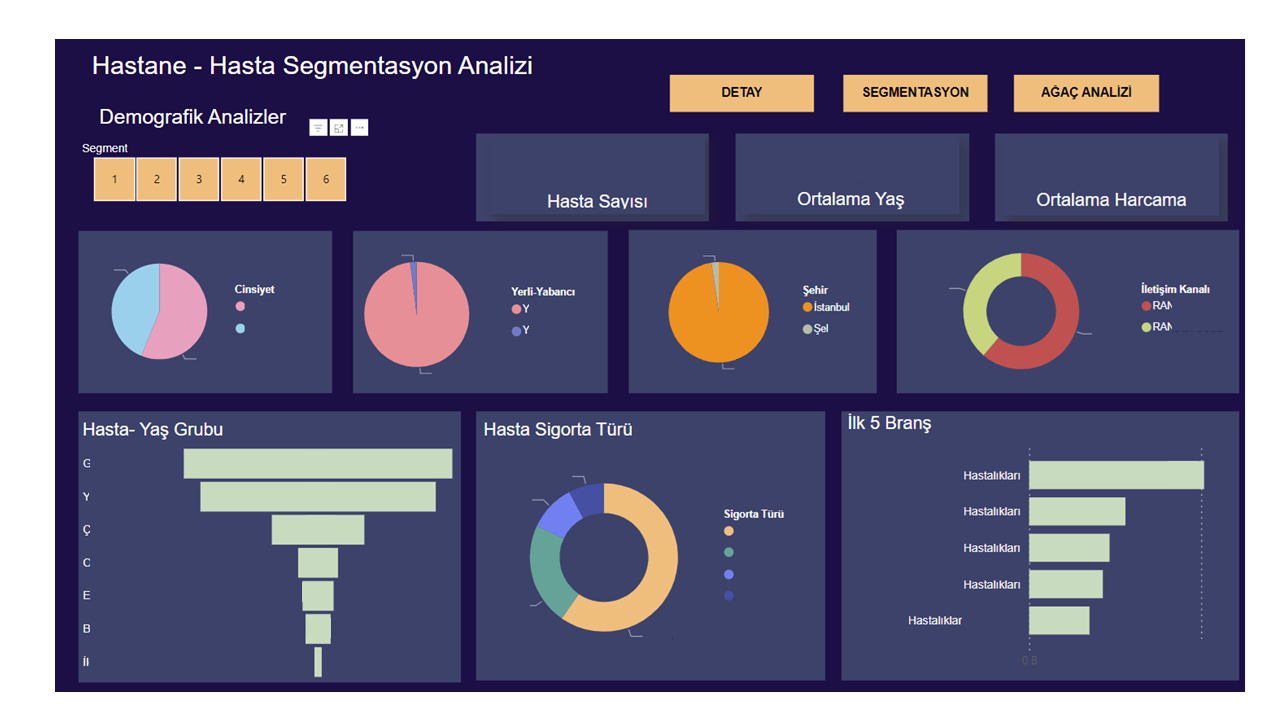

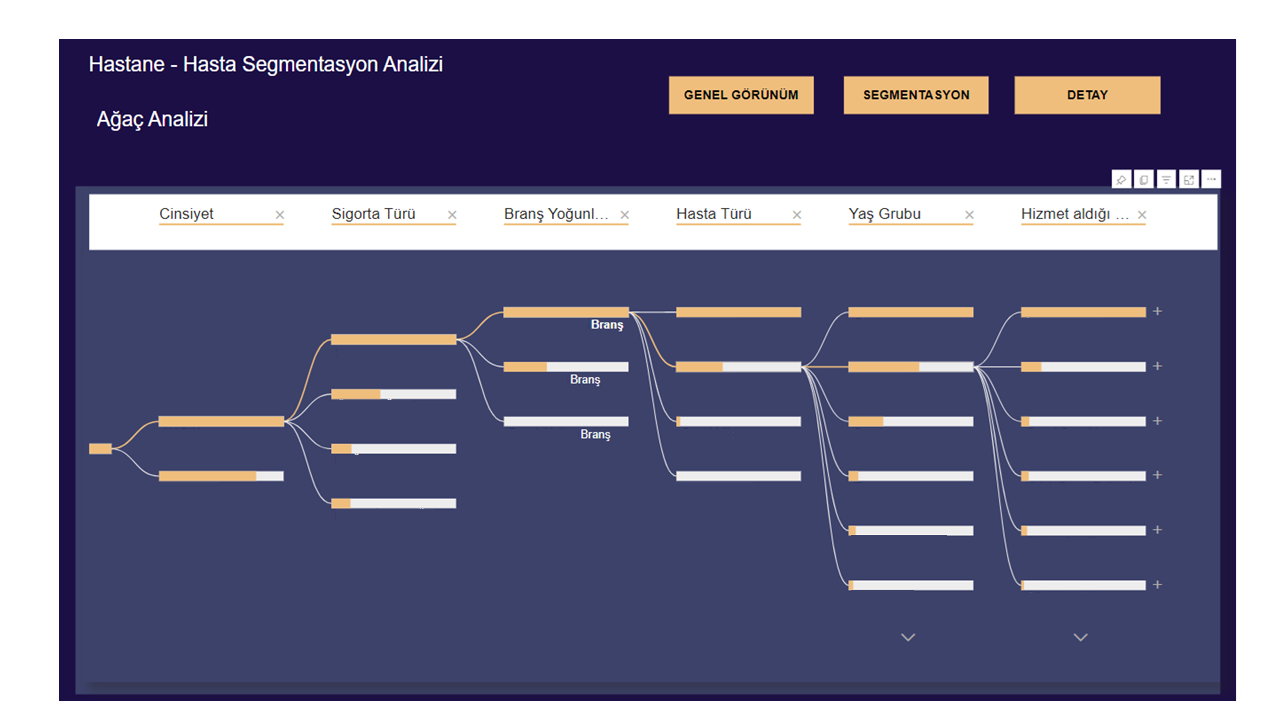

##############################################################################################

## Exploratory Data Analysis-2 

In [ ]:
# Re-check the overall structure and completeness of the merged dataset
check_df(df_merged)

# Identify the updated lists of categorical and numerical columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df_merged)

In [ ]:
# Categorical variable analysis
cat_cols = [col for col in cat_cols if col not in ["Churn", "segment"]]
for col in cat_cols:
    cat_summary(df_merged, col)

# Numerical variable analysis
num_cols = [col for col in num_cols if col not in ["İşlem Tarihi", "Müşteri_ID"]]
for col in num_cols:
    num_summary(df_merged, col, plot=False)

In [ ]:
# Numerical variables vs target variable analysis (Churn)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    print("################################################")

for col in num_cols:
    target_summary_with_num(df_merged, "Churn", col)


In [ ]:
# Categorical variables vs target variable analysis (Churn)
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")
    print("#################################################################################")

for col in cat_cols:
    target_summary_with_cat(df_merged, "Churn", col)

Observations from categorical analysis:
 - Gender: Males have a slightly higher churn rate than females.
 - City: Customers from outside Istanbul have a much higher churn rate, though they represent a small proportion.
 - District: Various districts show different churn rates. Notably, "DİĞER" (0.456) and "BEŞİKTAŞ" (0.364) have higher churn rates.
 - Local-Foreign Patient: Foreign patients have a high churn rate, but they constitute less than 1% of the data.
 - Insurance Type: Customers with private health insurance have higher churn rates.
 - Patient Type: Day patients and emergency patients have high churn rates, though they represent less than 4% of the data. Clinic patients have a churn rate of 46%.
 - Communication Channel: Patients without an appointment have a higher churn rate.
 - Region: The 3rd region shows higher churn rates compared to other regions.
 - Branch Intensity: Patients from low-intensity branches have a significantly higher churn rate, though they constitute only about 1% of the data.
 - Treatment Classification: Rarely performed treatments show higher churn rates, though the differences are not very pronounced.
 - Age Group: Adolescents, advanced, and middle-aged patients have higher churn rates compared to other age groups, though the differences are not very pronounced.

Potential features for the churn model:
- District
- Insurance Type
- Patient Type
- Communication Channel
- Region
- Treatment Classification
- Age Group

In [ ]:
# Correlation analysis for numerical variables
df_merged[num_cols].corr()

# Plot the correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df_merged[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# The correlation analysis does not show any strong correlations between numerical variables.

 We've already performed some feature engineering based on domain knowledge. Let's check for any remaining opportunities.

In [ ]:
# MISSING VALUE ANALYSIS
# We've already checked for missing values in the general overview, and there were none.

# OUTLIER ANALYSIS

# Function to determine outlier thresholds
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Function to check for outliers in a column
def check_outlier(dataframe, col_name):
    if dataframe[col_name].dtype.kind in 'bifc':  # Check if the column is numeric
        low_limit, up_limit = outlier_thresholds(dataframe, col_name)
        outlier_present = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
        if outlier_present.any():
            return True
        else:
            return False
    else:
        return False  # Return False for non-numeric columns

# Check for outliers in numerical variables
for col in num_cols:
    print(col, check_outlier(df_merged, col))  # Outliers are found in the 'Toplam Harcama' column

In [ ]:
# Count the number of outliers in the 'Toplam Harcama' column
def grab_outliers(dataframe, col_name, index=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)]

    if outliers.shape[0] > 0:
        if index:
            return outliers.index  # Return the indices of the outliers
        else:
            return outliers  # Return the DataFrame of outliers
    else:
        print(f"No outliers found in {col_name}")
        return pd.DataFrame()  # Return an empty DataFrame if no outliers are found

outlier_data = grab_outliers(df_merged, 'Toplam Harcama')
print(f"Number of outliers in Toplam Harcama: {outlier_data.shape[0]}")  # There are 7,516 outliers

# Given the small percentage of outliers, we choose to ignore them, especially since we plan to use tree-based methods where outliers are less impactful.

## Feature Engineering / Extraction

In [ ]:
# FEATURE EXTRACTION
# Review unique values in each column to identify opportunities for new features
for column in df_merged.columns:
    unique_values = df_merged[column].unique()
    print(f"{column} column unique values: {unique_values}")

# Based on our previous analysis, let's create new features by combining significant categories.

# Create a new feature based on gender and insurance type
df_merged.loc[(df_merged["Cinsiyet"] == "ERKEK") & (df_merged["Sigorta Türü"] == "ÖZEL SAĞLIK"), "NEW_Sigorta"] = "OzelSigortaliErkek"
df_merged.loc[(df_merged["Cinsiyet"] == "KADIN") & (df_merged["Sigorta Türü"] == "ÖZEL SAĞLIK"), "NEW_Sigorta"] = "OzelSigortaliKadin"
df_merged.loc[df_merged["Sigorta Türü"] != "ÖZEL SAĞLIK", "NEW_Sigorta"] = "OzelSigortaliDegil"

# Create a new feature based on patient type and communication channel
df_merged.loc[(df_merged["Hasta Türü"] == "Klinik") & (df_merged["İletişim Kanalı"] == "RANDEVUSUZ"), "NEW_Hasta_Turu"] = "RandevusuzKlinikHasta"
df_merged.loc[(df_merged["Hasta Türü"] == "Klinik") & (df_merged["İletişim Kanalı"] == "RANDEVU"), "NEW_Hasta_Turu"] = "RandevuluKlinikHasta"
df_merged.loc[df_merged["Hasta Türü"] != "Klinik", "NEW_Hasta_Turu"] = "KlinikOlmayanHasta"

df_merged.head()
print(df_merged.shape)  # The dataset now contains 21 variables


## Encoding

In [ ]:
# Separate categorical and numerical columns for encoding
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df_merged)

# Back up the dataset before encoding
df_merged1 = df_merged.copy()


In [ ]:
# Label Encoding for binary categorical variables
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)  # Binary columns: ['Cinsiyet', 'Şehir', 'Yerli-Yabancı Hasta', 'İletişim Kanalı']

# Apply label encoding to binary columns
for col in binary_cols:
    df_merged = label_encoder(df_merged, col)

In [ ]:
# Rare Encoding
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in "Churn"]
print(cat_cols)
# ['İlçe', 'Sigorta Türü', 'Hasta Türü', 'Bölge', 'Branş Yoğunluğu', 'Tedavi Sınıflandırması', 'NEW_Sigorta', 'NEW_Hasta_Turu', 'Yaş Grubu', 'segment']

# Analyze rare categories to determine if they need to be combined
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df_merged, "Churn", cat_cols)  # Review for rare categories

# Apply rare encoding to combine categories with low frequency
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

# Apply rare encoding with a threshold of 2%
df_merged = rare_encoder(df_merged, 0.02)
rare_analyser(df_merged, "Churn", cat_cols)  # Recheck the rare categories after encoding

In [ ]:
# One-Hot Encoding
df_merged.drop(["segment"], axis=1, inplace=True)  # Drop the 'segment' column as it was used for churn analysis, not for modeling

# Update the list of categorical columns
cat_cols = [col for col in cat_cols if col not in "segment"]
print(cat_cols)

# Apply one-hot encoding to categorical variables
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_merged = one_hot_encoder(df_merged, cat_cols, drop_first=True)
df_merged.head()  # The categorical columns have been converted into dummy variables

# Convert boolean columns to integers (0 and 1)
for col in df_merged.columns:
    if df_merged[col].dtype == 'bool':
        df_merged[col] = df_merged[col].astype(int)

# Standardize numerical columns
print(num_cols)  # ['Yaş', 'İşlem Tarihi', 'Toplam Harcama', 'Müşteri_ID']
num_cols = [col for col in num_cols if col not in ['Müşteri_ID', 'İşlem Tarihi']]  # Update the list of numerical columns

scaler = MinMaxScaler()
df_merged[num_cols] = scaler.fit_transform(df_merged[num_cols])

# The dataset is now ready for machine learning modeling

## Modeling

In [ ]:
# Prepare the data for modeling
y = df_merged["Churn"]
X = df_merged.drop(["Churn", "Müşteri_ID", "İşlem Tarihi", "Hizmet aldığı Branş", "Tedavi Adı"], axis=1)

# Compare base models to identify the best model for our dataset
def base_models(X, y, scoring="accuracy"):
    print("Base Models...")
    models = [('LR', LogisticRegression()),
              ('KNN', KNeighborsClassifier()),
              ('CART', DecisionTreeClassifier()),
              ('RF', RandomForestClassifier()),
              ('GBM', GradientBoostingClassifier()),
              ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
              ("LightGBM", LGBMClassifier()),
              ("CatBoost", CatBoostClassifier(verbose=False))]

    for name, classifier in models:
        cv_results = np.mean(cross_val_score(classifier, X, y, cv=5, scoring="accuracy"))
        print(f"{scoring}: {round(cv_results, 4)} ({name})")

base_models(X, y, scoring="accuracy")


Accuracy: 0.7215 (LR) 
Accuracy: 0.7313 (KNN)  
Accuracy: 0.7333 (CART)  
Accuracy: 0.7586 (RF)  
Accuracy: 0.7437 (GBM) 
Accuracy: 0.7646 (XGBoost) -- 
Accuracy: 0.7573 (LightGBM)  
Accuracy: 0.7668(CatBoost) -- 

The best performing models are XGBoost and CatBoost. We will proceed with hyperparameter tuning for XGBoost and CatBoost.


In [ ]:
# Evaluate XGBoost and CatBoost before hyperparameter tuning

xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=46)
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(round(cv_results["test_accuracy"].mean(), 4))  
print(round(cv_results["test_f1"].mean(), 4))      
print(round(cv_results["test_roc_auc"].mean(), 4))  


catboost_model = CatBoostClassifier(verbose=False, random_state=46)
cv_results2 = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(round(cv_results2["test_accuracy"].mean(), 4))  
print(round(cv_results2["test_f1"].mean(), 4))       
print(round(cv_results2["test_roc_auc"].mean(), 4))  


XGBoost Results:
- Accuracy: 0.7646
- F1: 0.5165
- ROC AUC: 0.7954

CatBoost Results:
- Accuracy: 0.7668
- F1: 0.5195
- ROC AUC: 0.7977

In [ ]:
# Both models perform similarly, but we'll proceed with XGBoost due to slightly better interpretability and faster tuning.

print(xgboost_model.get_params())  # View the default hyperparameters for XGBoost

# Set up the parameter grid for hyperparameter tuning
xgboost_params = {"max_depth": [3, 6],
                  "learning_rate": [0.1, 0.01],
                  "n_estimators": [100, 500]
                  }

classifiers = [("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=46), xgboost_params)]


def hyperparameter_optimization(X, y, cv=5, scoring="roc_auc"):
    print("Hyperparameter Optimization...")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"############   {name}   ##############")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring}(Before): {round(cv_results['test_score'].mean(), 4)}")
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring}(After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params:{gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

# Perform hyperparameter tuning
best_models = hyperparameter_optimization(X, y)

After tuning:
- XGBoost ROC AUC (Before): 0.79
- XGBoost ROC AUC (After):  0.8
- Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

The ROC AUC score improved slightly after tuning, indicating the benefit of hyperparameter optimization.

In [ ]:
# Train the final model with the best parameters
final_model = best_models["XGBoost"]
final_model.fit(X, y)

# Predict churn for a random customer to test the model
random_user = X.sample(1, random_state=45)
final_model.predict(random_user)  # The prediction shows that the customer with ID 81326 is likely to churn

## Feature importance

In [ ]:
# Feature importance analysis to identify the most impactful features in the model
def plot_importance(model, X, num=len(X), save=False):
    # Get feature importance values
    importances = model.feature_importances_
    # Match feature names with importance values
    feature_names = X.columns.tolist()
    feature_imp = pd.DataFrame({'Feature': feature_names, 'Value': importances})

    # Select and visualize the top features
    top_features = feature_imp.sort_values(by="Value", ascending=False).head(num)
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=top_features)
    plt.title('Top {} Important Features'.format(num))
    plt.xlabel('Importance Value')
    plt.ylabel('Features')
    plt.show()
    if save():
        plt.savefig("importances.png")

plot_importance(final_model, X, num=10)


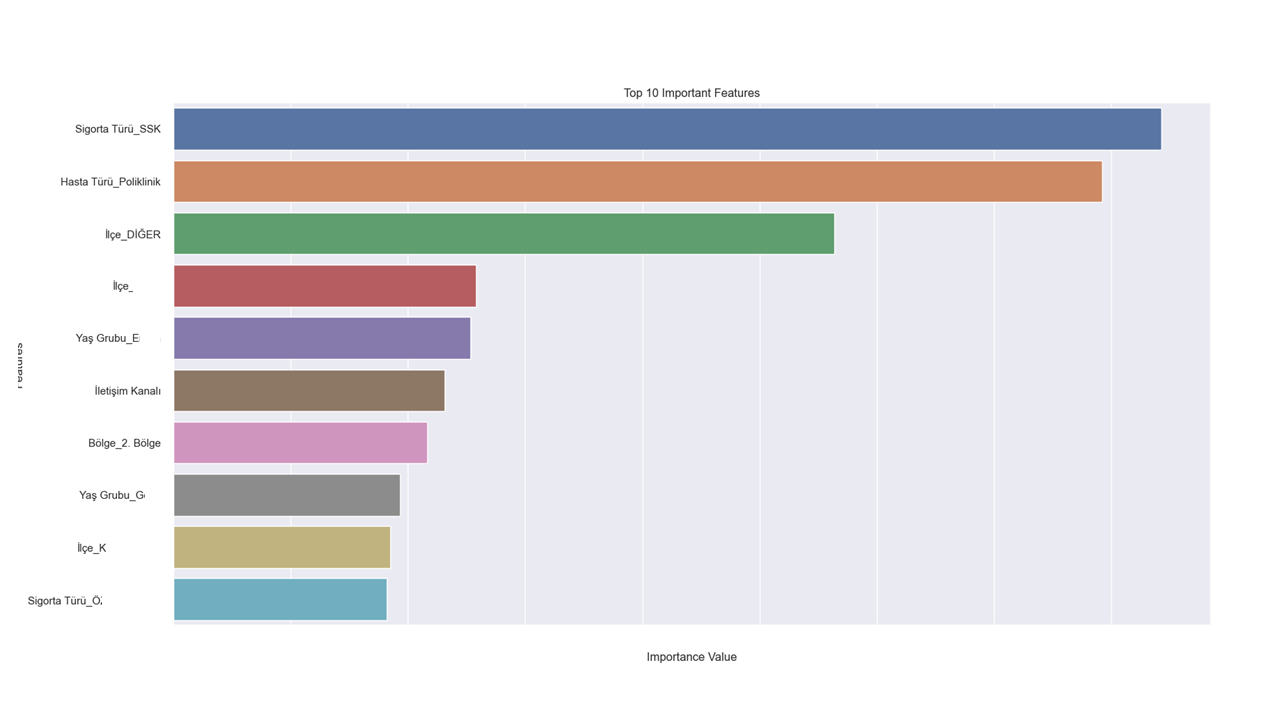

Insights:
- Insurance Type (SSK) and Patient Type (Polyclinic) are the most important features in predicting churn.
- Districts like 'DİĞER' also play a significant role in churn prediction.

Further feature engineering could focus on these important features to enhance model performance.

## Use Model for Prediction

In [ ]:
# Save the final model for future use
joblib.dump(final_model, "final_model.pkl")

# Load the saved model for use in future predictions
new_model = joblib.load("final_model.pkl")

# Test the model with a new random customer sample
random_user = X.sample(1, random_state=10)  # Customer ID 236918
new_model.predict(random_user)  # The prediction shows that the customer with ID 236918 is not likely to churn

# Verify the churn status of the customer with ID 236918
new_id = 236918
ischurn = df_merged[df_merged["Müşteri_ID"] == new_id]["Churn"]
print(f"Müşteri ID {new_id} için Churn durumu: {ischurn.iloc[0]}")

# The customer with ID 236918 is confirmed not to churn based on the model prediction.

## Outcome

- Detailed segmentation was prepared based on patients' demographic characteristics, past treatment information, and spending habits.
- High-contribution and high-spending potential patient groups were identified.
- A dashboard was created for the analysis of patients based on their segments.
- A patient churn model with an 80% ROC_AUC score was developed using XGBoost.
- The churn prediction model will help strengthen patient loyalty.

## How to Improve

In [ ]:
- Generate more features based on the variables with higher impact according to the feature importance analysis.
- Increase the number of hyperparameter values considered during tuning.
- Increase the number of cross-validation folds to enhance model robustness.